<h1 style='text-align:center; color:blue;'> Healthcare Premium Prediction Model</h1>

## Import Libraries

In [118]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ridge_regression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

## Data Loading

In [119]:
df=pd.read_excel("premium_young_vishant.xlsx")
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Check shape of data

In [120]:
df.shape

(20096, 13)

### Convert columns into lower case

In [121]:
df.columns=df.columns.str.replace("_", " ").str.lower()
df.columns=df.columns.str.replace(" ", "_").str.lower()

## Exploratory Data-analysis and data cleaning

### Handle Missing value

In [122]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [123]:
df.dropna(inplace=True)

In [124]:
df.shape

(20090, 13)

In [125]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicate values

In [126]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [127]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


#### Data Cleaning: number of dependants

In [128]:
df[df.number_of_dependants<0].shape

(22, 13)

In [129]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df[df.number_of_dependants<0].shape

(0, 13)

In [130]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


## 1. Numeric Columns

### Univariate Analysis:Numeric Columns

#### Box plot for numeric columns

In [131]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [132]:
numeric_columns=df.select_dtypes(include='number').columns    ## or df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [133]:
num_rows=int(len(numeric_columns)/2)
num_rows

2

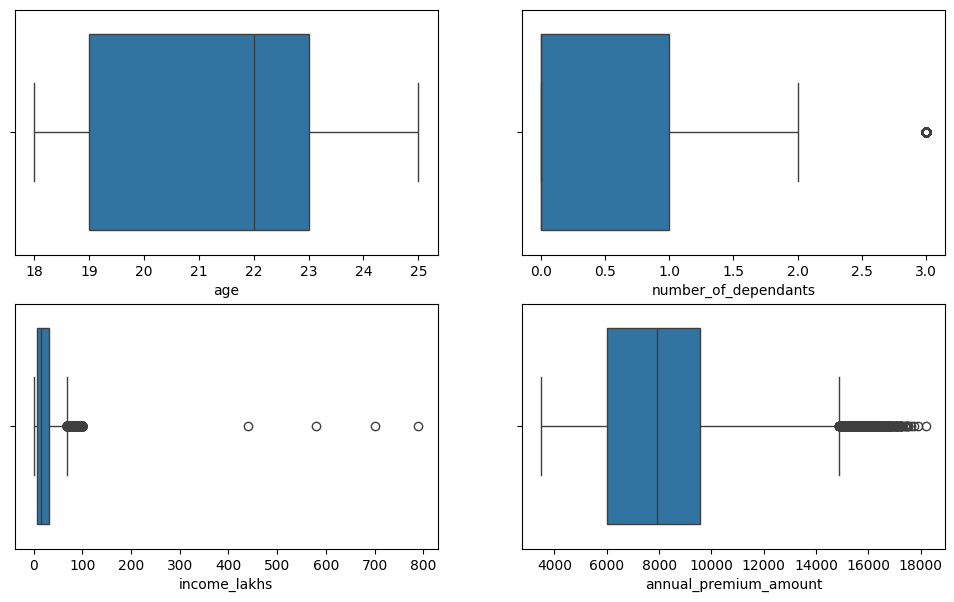

In [134]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axis[i])
plt.show()

### Outlier treatment: Age column

In [135]:
df.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

In [136]:
df[df['age']>100].shape

(0, 13)

In [137]:
def limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

limits('age')

(np.float64(13.0), np.float64(29.0))

In [138]:
df['age'].quantile(0.25)

np.float64(19.0)

In [139]:
df['age'].quantile(0.75)

np.float64(23.0)

In [140]:
df['age'].quantile(0.99)

np.float64(25.0)

In [141]:
df[df['age']>100].age.shape

(0,)

In [142]:
df1=df[df['age']<100].copy()
df1

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603
20092,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Diabetes,Gold,14498
20093,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111
20094,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564


In [143]:
df1.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

### Outlier treatment :Income columns

In [144]:
def get_iqr_limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

get_iqr_limits('income_lakhs')

(np.float64(-31.5), np.float64(68.5))

In [145]:
df1[df1['income_lakhs']>67].shape

(1335, 13)

In [146]:
income_thershold=df1['income_lakhs'].quantile(0.999)
income_thershold

np.float64(100.0)

In [147]:
df2=df1[df1['income_lakhs']<=income_thershold].copy()
df2.shape

(20086, 13)

In [148]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


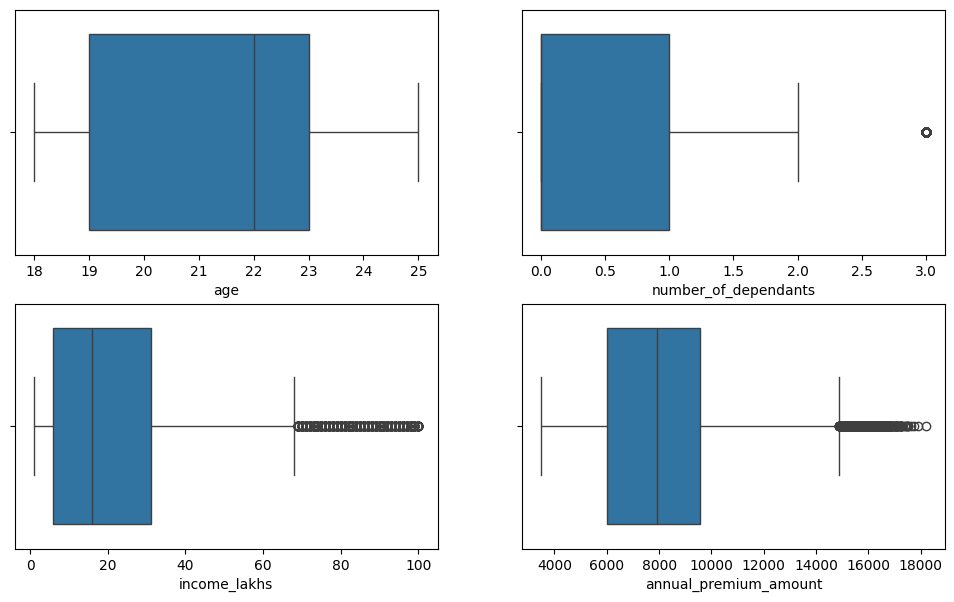

In [149]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df2[col], ax=axis[i])
plt.show()

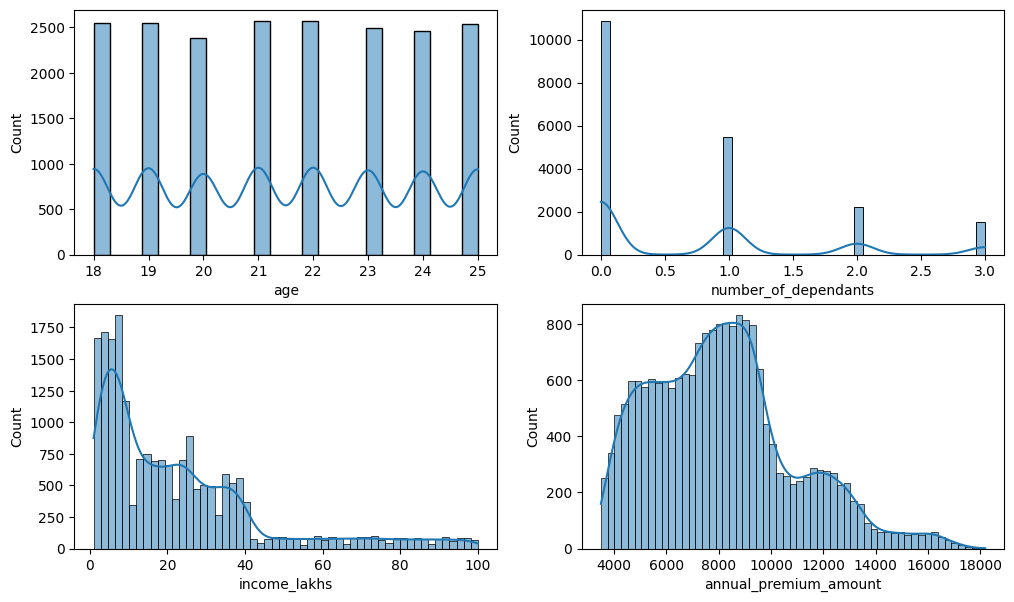

In [150]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(x=df2[col], ax=axis[i], kde=True)
plt.show()

In [151]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


### Bivariate Analysis:Numeric Columns

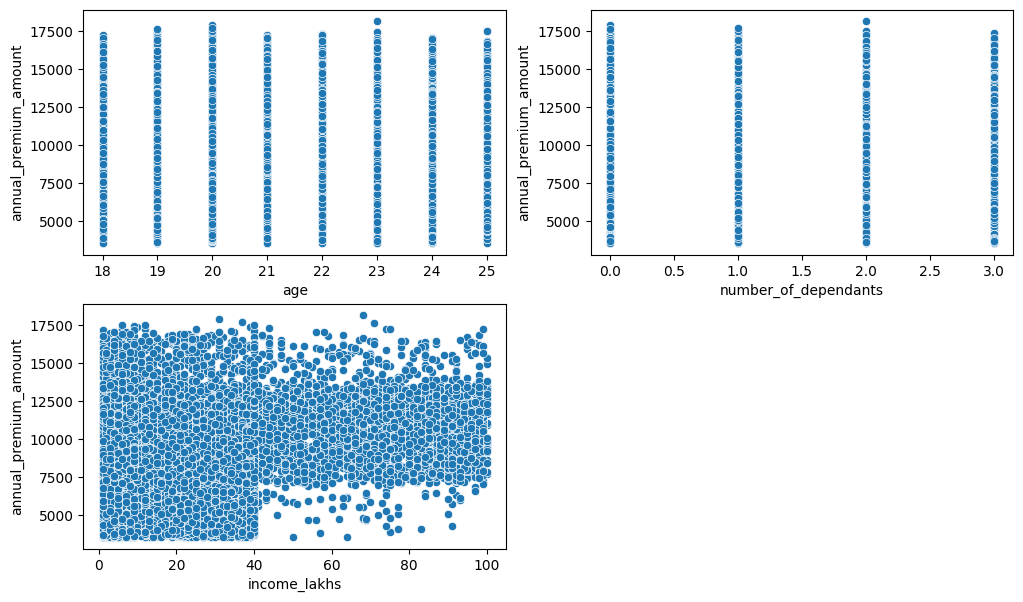

In [152]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=axis[i])


for i in range(len(numeric_columns)-1,len(numeric_columns)):
    figure.delaxes(axis[i])


plt.show()

## 2. Categorical Columns

In [153]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    20086 non-null  int64 
 1   gender                 20086 non-null  object
 2   region                 20086 non-null  object
 3   marital_status         20086 non-null  object
 4   number_of_dependants   20086 non-null  int64 
 5   bmi_category           20086 non-null  object
 6   smoking_status         20086 non-null  object
 7   employment_status      20086 non-null  object
 8   income_level           20086 non-null  object
 9   income_lakhs           20086 non-null  int64 
 10  medical_history        20086 non-null  object
 11  insurance_plan         20086 non-null  object
 12  annual_premium_amount  20086 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 2.1+ MB


In [154]:
categorical_cols=df2.select_dtypes(include=['object']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [155]:
for col in categorical_cols:
    print(f" {col}--->{df2[col].unique()}")
    print("-"*50)

 gender--->['Male' 'Female']
--------------------------------------------------
 region--->['Northeast' 'Northwest' 'Southeast' 'Southwest']
--------------------------------------------------
 marital_status--->['Unmarried' 'Married']
--------------------------------------------------
 bmi_category--->['Overweight' 'Underweight' 'Normal' 'Obesity']
--------------------------------------------------
 smoking_status--->['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
--------------------------------------------------
 employment_status--->['Self-Employed' 'Freelancer' 'Salaried']
--------------------------------------------------
 income_level--->['> 40L' '<10L' '10L - 25L' '25L - 40L']
--------------------------------------------------
 medical_history--->['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
-------

In [156]:
df2['smoking_status']=df2['smoking_status'].replace({'Smoking=0':'No Smoking',
                                                     'Does Not Smoke':'No Smoking',
                                                     'Not Smoking':'No Smoking'})

In [157]:
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis

In [158]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [159]:
pct_count=df2.gender.value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

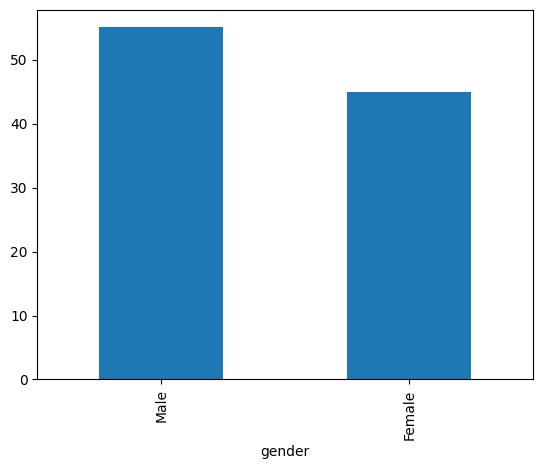

In [160]:
pct_count.plot(kind='bar')
plt.show()

In [161]:
num_rows_1=int(len(categorical_cols)/3)
num_rows_1

3

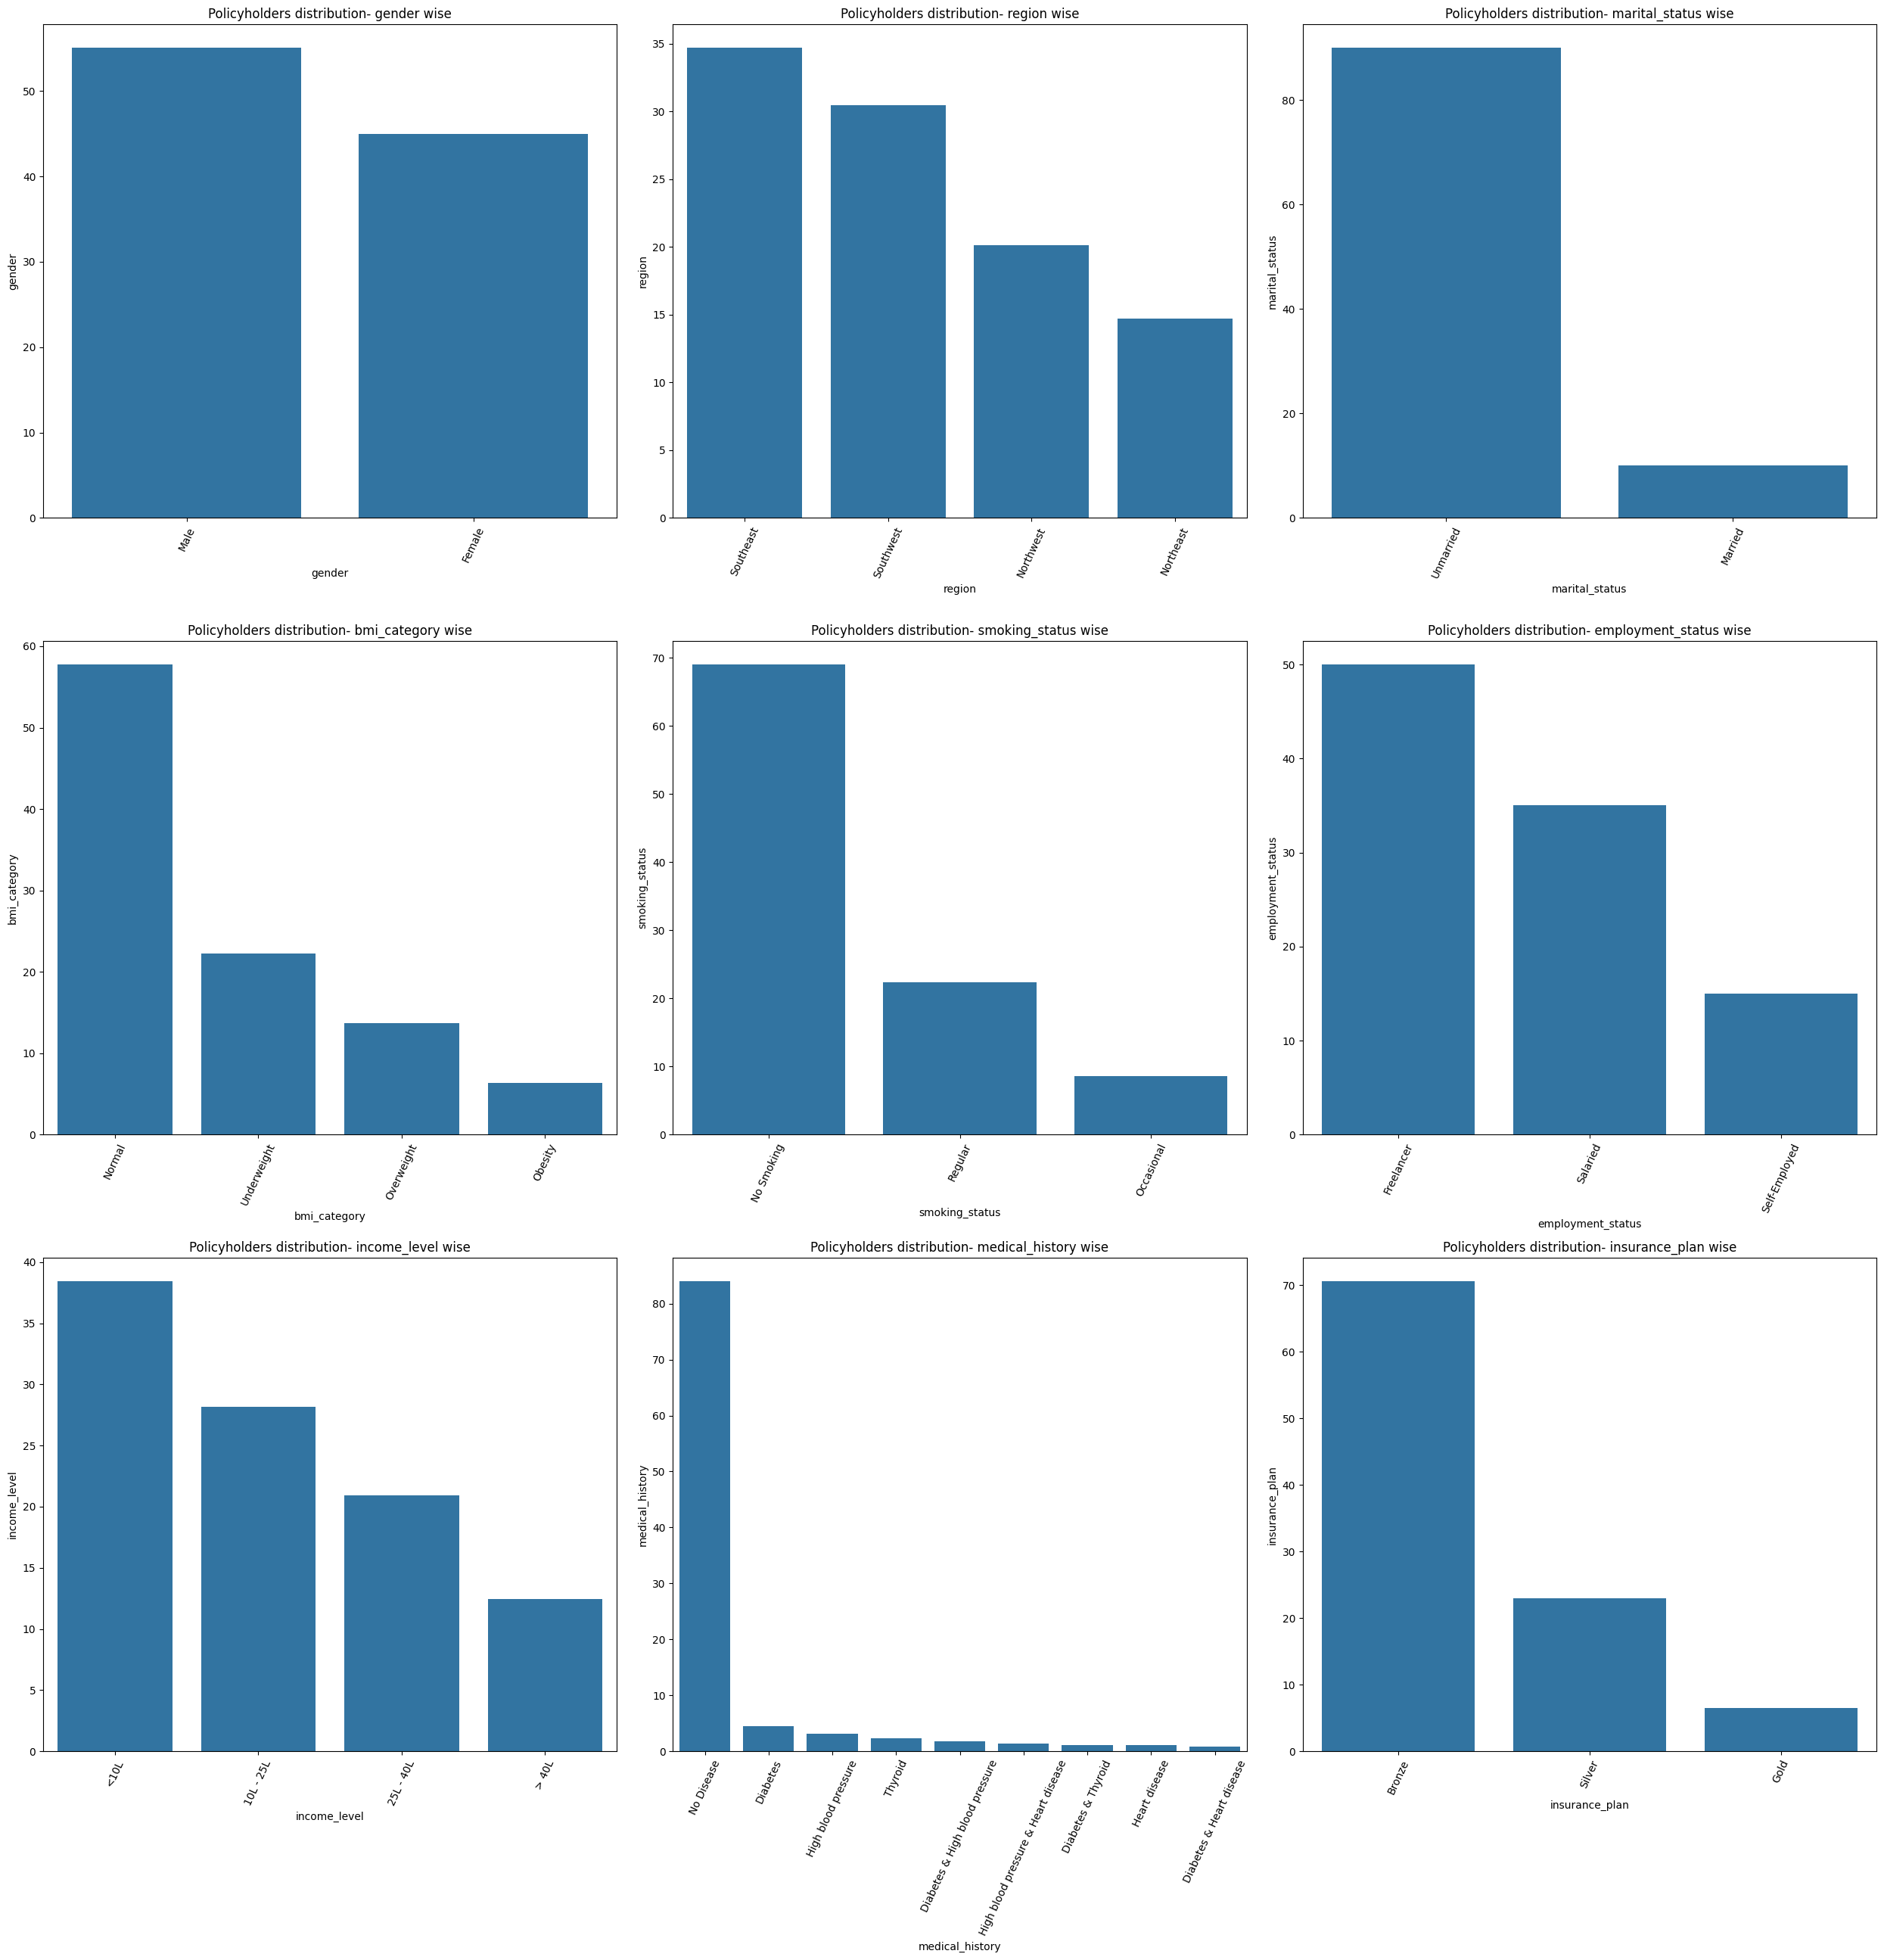

In [162]:
figure, axis=plt.subplots(num_rows_1, 3, figsize=(25, num_rows*13))
axis=axis.flatten()

for i, col in enumerate(categorical_cols):
    pct_count=df2[col].value_counts(normalize=True)*100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=axis[i])
    axis[i].set_title(f"Policyholders distribution- {col} wise")
    axis[i].set_ylabel(col)
    axis[i].tick_params(axis='x', rotation=65)
plt.tight_layout()
plt.show()

###  Bivariate Analysis

In [163]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [164]:
df3=df2.groupby(['income_level', 'insurance_plan'])[['insurance_plan']].count()
df3

insurance_plan
income_level insurance_plan                
10L - 25L    Bronze                    4508
             Gold                       326
             Silver                     828
25L - 40L    Bronze                    3382
             Gold                       209
             Silver                     608
<10L         Bronze                    6172
             Gold                       404
             Silver                    1145
> 40L        Bronze                     115
             Gold                       366
             Silver                    2023

<Axes: xlabel='income_level', ylabel='insurance_plan'>

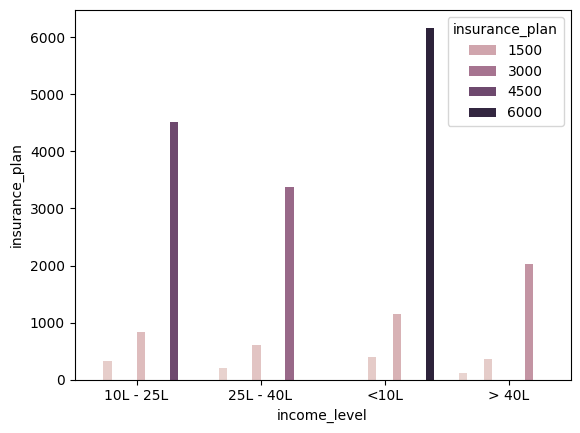

In [165]:
sns.barplot(data=df3, x='income_level', y='insurance_plan', hue='insurance_plan')

In [166]:
cross_tab=pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


<Axes: xlabel='income_level'>

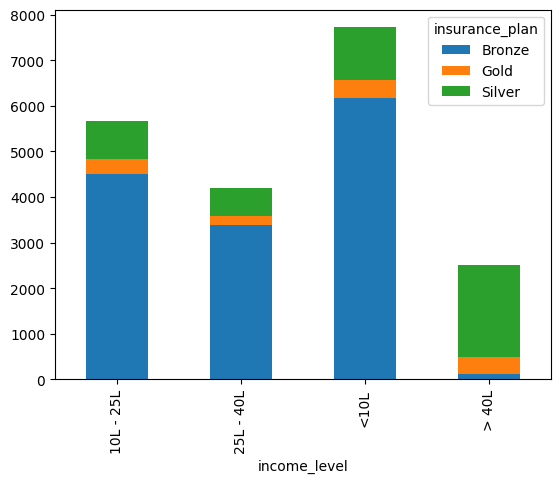

In [167]:
cross_tab.plot(kind='bar', stacked=True)

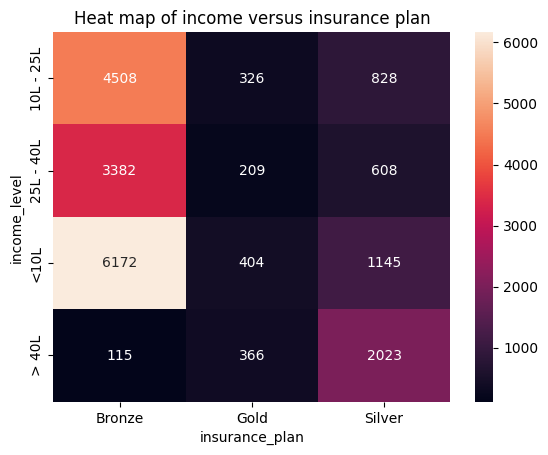

In [168]:
sns.heatmap(data=cross_tab, annot=True, fmt='d')
plt.title("Heat map of income versus insurance plan")
plt.show()

##  Feature Engineering

###  Calculate Risk Score

In [169]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [170]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [171]:
#define risk score for each condition
risk_score={"diabetes":6, "heart disease":8, "high blood pressure":6, "thyroid" :5, "no Disease":0, 'none':0}
df2[["disease_1","disease_2"]]=df2['medical_history'].str.split(" & ", expand=True).apply(lambda x:x.str.lower())
df2['disease_1']=df2['disease_1'].fillna('none')
df2['disease_2']=df2['disease_2'].fillna('none')

df2['total_risk_score']=0
for disease in ['disease_1', 'disease_2']:
    df2[disease]=df2[disease].map(risk_score)
    df2['total_risk_score']+=df2[disease]

In [172]:
df2['total_risk_score']=df2['total_risk_score'].fillna(0)

In [173]:
#normalization of risk score

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df2['normalized_risk_score']=scaler.fit_transform(df2[['total_risk_score']])
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,6.0,0,6.0,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,NaN,0,0.0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,NaN,0,0.0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,NaN,0,0.0,0.000000


### Encode Text column

In [174]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1, 'Silver':2,'Gold':3})

In [175]:
df2.insurance_plan.unique()

array([2, 1, 3])

In [176]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [177]:
df2['income_level']=df2['income_level'].map({'<10L':1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})

In [178]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'disease_1', 'disease_2', 'total_risk_score',
       'normalized_risk_score'],
      dtype='object')

In [179]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']

df3=pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

In [180]:
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,2,13365,6.0,0,6.0,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,NaN,0,0.0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,2,11857,NaN,0,0.0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,NaN,0,0.0,...,1,0,1,0,0,0,0,0,0,0


In [181]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   disease_1                        3213 non-null   float64
 8   disease_2                        20086 non-null  int64  
 9   total_risk_score                 20086 non-null  float64
 10  normalized_risk_score            20086 non-null  float64
 11  gender_Male                      20086 non-null  int64  
 12  region_Northwest       

### Feature Selection

In [182]:
dropped_columns=['medical_history', 'total_risk_score', 'disease_1', 'disease_2']
df4=df3.drop(dropped_columns, axis=1)

In [183]:
df4

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,18,0,3,91,3,11603,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20092,23,0,3,57,3,14498,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20093,24,0,4,35,1,9111,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20094,21,0,4,32,1,8564,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


### Calculate VIF for multicolinearity

In [184]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

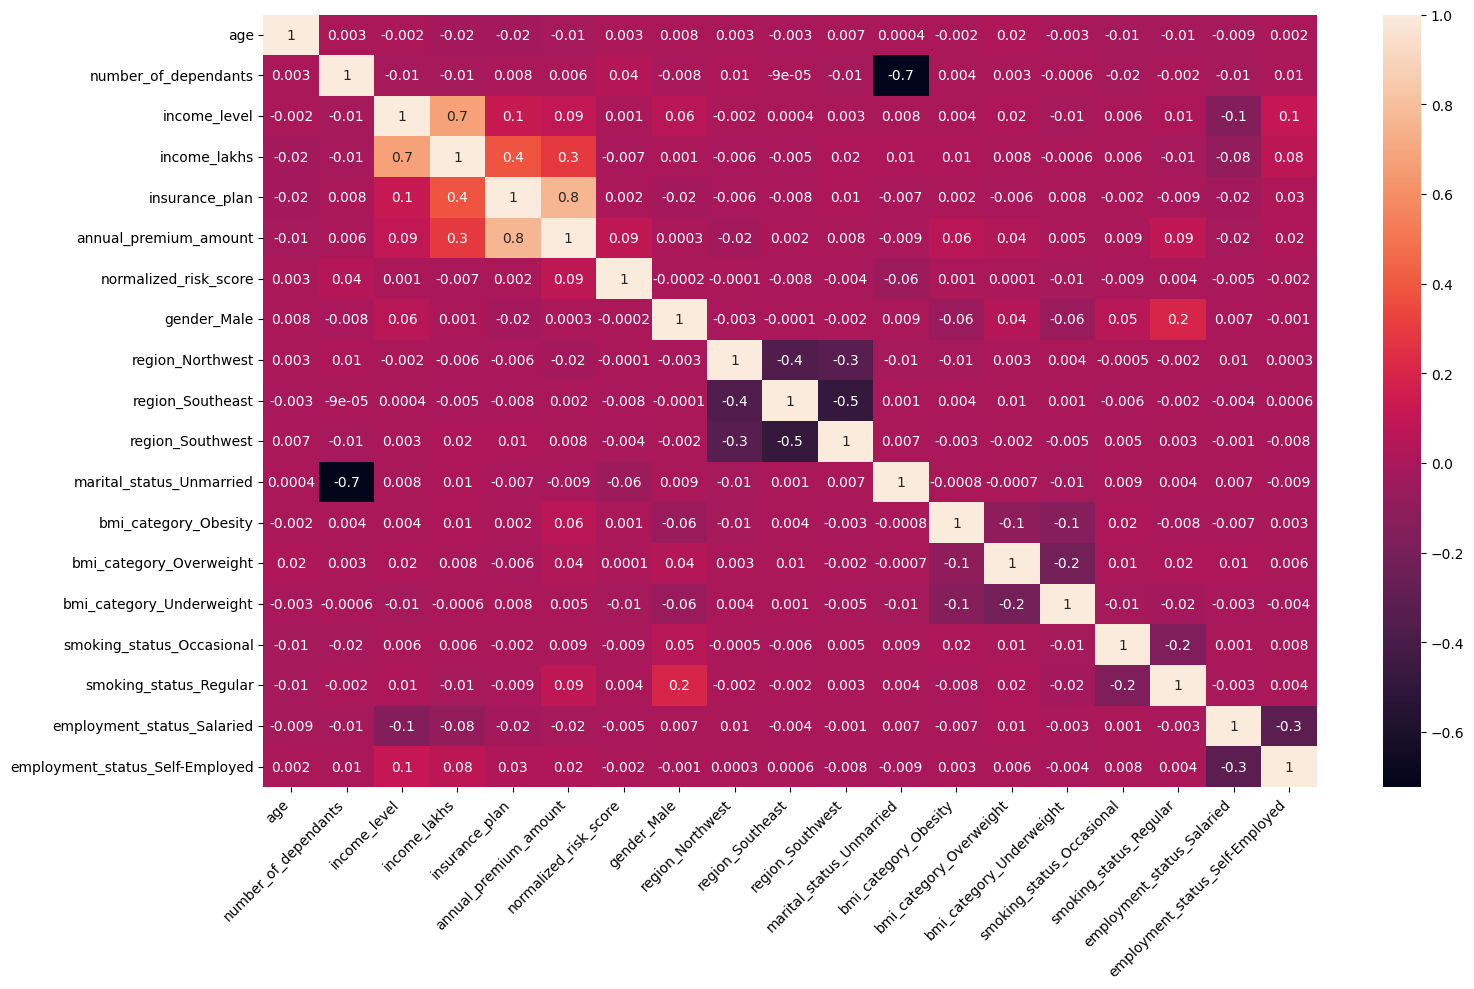

In [185]:
cm=df4.corr()

plt.figure(figsize=(16,10))
sns.heatmap(cm, annot=True, fmt='0.1g')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [186]:
X=df4.drop('annual_premium_amount', axis=1)
y=df4['annual_premium_amount']
scaler=MinMaxScaler()
cols=['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
X[cols]=scaler.fit_transform(X[cols])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.386123,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.383007,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [187]:
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data.values,i) for i in range (data.shape[1])]
    return vif_df

In [188]:
calculate_vif(X)

,variable,VIF
0,age,3.144224
1,number_of_dependants,1.867394
2,income_level,3.915844
3,income_lakhs,4.343596
4,insurance_plan,1.647480
5,normalized_risk_score,1.154461
6,gender_Male,2.317166
7,region_Northwest,2.148426
8,region_Southeast,2.971750
9,region_Southwest,2.731418


In [189]:
calculate_vif(X.drop('income_level', axis=1))

,variable,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [190]:
X_reduced=X.drop('income_level', axis=1)

##  Model Training

In [191]:
X_train, X_test, y_train, y_test=train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#print shape of X_reduced, X_train, X_test, y_train, y_test features
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_reduced shape: (20086, 17)
X_train shape: (14060, 17)
X_test shape : (6026, 17)
y_train shape: (14060,)
y_test shape: (6026,)


### Linear Regression model

In [192]:
model_lr=LinearRegression()
#training a model
model_lr.fit(X_train, y_train)

#predicting model r2 score
test_score=model_lr.score(X_test, y_test)
train_score=model_lr.score(X_train, y_train)
test_score, train_score

(0.6006143379050812, 0.6038233962462742)

In [193]:
#prediction values
y_pred=model_lr.predict(X_test)

#RMSE 
mse=mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
print(f"Linear Regression MSE {mse}, RMSE: {rmse}")

Linear Regression MSE 3042911.242917955, RMSE: 1744.394233800936


In [194]:
len(model_lr.coef_)

17

In [195]:
len(X_train.columns)

17

In [196]:
feature_importance=model_lr.coef_
feature_importance

array([ 2.36884148e+01, -2.81603858e+01,  6.06515998e+01,  6.97000722e+03,
        1.14617372e+03,  2.27709031e+00, -8.85129128e+01, -2.63407586e+00,
        4.00535339e-01,  3.11161583e+00,  8.48014989e+02,  3.85748545e+02,
        1.86980641e+02,  2.89716954e+02,  6.32388157e+02,  7.72265002e+00,
        2.18415123e+01])

In [197]:
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

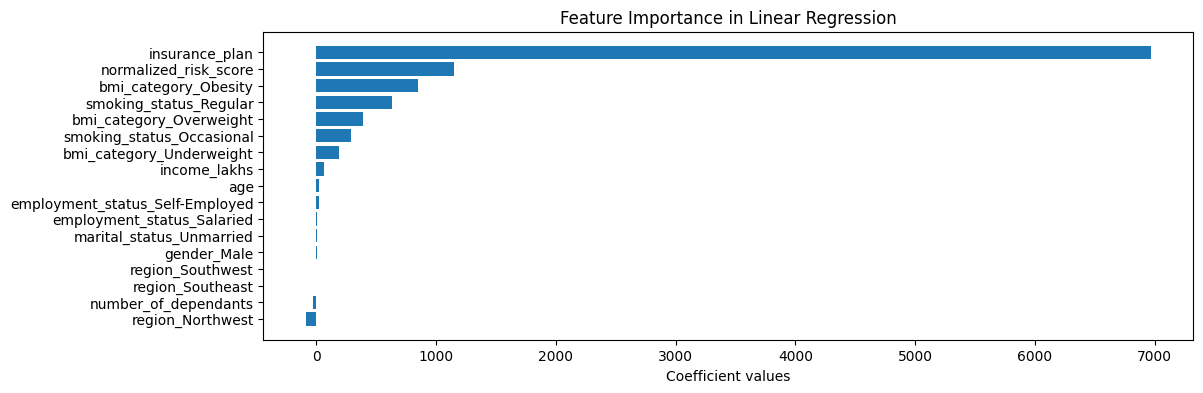

In [198]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression model

In [199]:
model_rg=Ridge(alpha=1)
model_rg.fit(X_train, y_train)

Ridge(alpha=1)

In [200]:
test_score_rg=model_rg.score(X_test, y_test)
train_score_rg=model_rg.score(X_train, y_train)
train_score, test_score

(0.6038233962462742, 0.6006143379050812)

In [201]:
y_pred_rg=model_rg.predict(X_test)
MSE_rg=mean_squared_error(y_test,y_pred_rg)
RMSE_rg=np.sqrt(MSE_rg)
R2_score_rg=r2_score(y_test,y_pred_rg)

print(f"RMSE of Ridge regression model {RMSE_rg}, R2 Score of Ridge regression {R2_score_rg}")

RMSE of Ridge regression model 1744.3869033138824, R2 Score of Ridge regression 0.6006176945835398


### XGBoost

In [202]:
model_xgb=XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [203]:
y_pred_xgb=model_xgb.predict(X_test)

In [204]:
test_score_xgb=model_xgb.score(X_test, y_test)
train_score_xgb=model_xgb.score(X_train, y_train)
train_score, test_score

(0.6038233962462742, 0.6006143379050812)

In [205]:
y_pred_xgb=model_xgb.predict(X_test)
MSE_xgb=mean_squared_error(y_test,y_pred_xgb)
RMSE_xgb=np.sqrt(MSE_xgb)
R2_score_xgb=r2_score(y_test,y_pred_xgb)

print(f"RMSE of Ridge regression model {RMSE_xgb}, R2 Score of Ridge regression {R2_score_xgb}")

RMSE of Ridge regression model 1829.120622047655, R2 Score of Ridge regression 0.5608752965927124


#### Randomized SearchCV

In [206]:
model_xgb=XGBRegressor()
param_grid={
            'n_estimators':[20,40,50],
            'learning_rate':[0.01,0.1,0.2],
            'max_depth':[3,4,5] }
random_search=RandomizedSearchCV(model_xgb, param_grid,n_iter=10, cv=3, scoring='r2',random_state=42, n_jobs=-1)
random_search

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [207]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [208]:
random_search.best_score_

np.float64(0.6011000474294027)

In [209]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [210]:
best_model=random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [211]:
feature_importance=best_model.feature_importances_

#create DataFrame for Data Handling
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

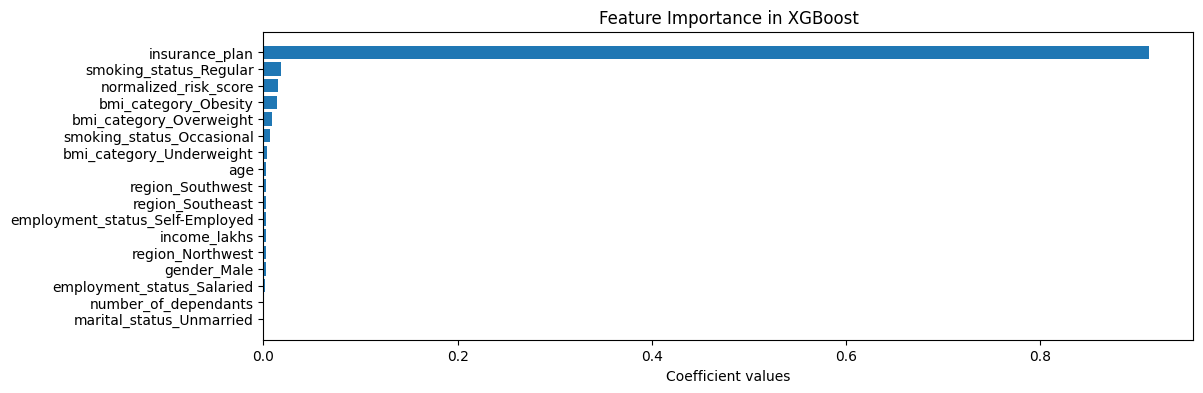

In [212]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in XGBoost')
plt.show()

Feature importance in XGBoost may not be as straightforward to interpret as feature importance in Linear Regression, Since XGBoost is a tree based model.

##  Error Analysis

In [213]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=residuals*100/y_test
result_df=pd.DataFrame({'Truth':y_test, 'Prediction':y_pred, 'diff':residuals, 'diff_pct':residuals_pct})
result_df

,Truth,Prediction,diff,diff_pct
10489,5452,6944.746094,1492.746094,27.379789
7989,9658,7533.948242,-2124.051758,-21.992667
3113,6031,8605.072266,2574.072266,42.680688
10605,12386,10463.995117,-1922.004883,-15.517559
4204,4245,7121.642090,2876.642090,67.765420
...,...,...,...,...
18960,4293,6577.392578,2284.392578,53.212033
266,11889,13420.101562,1531.101562,12.878304
10036,11876,10057.202148,-1818.797852,-15.314903
15506,13433,14221.446289,788.446289,5.869473


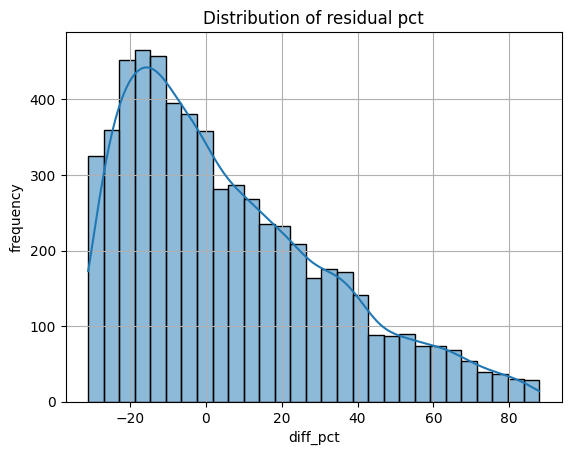

In [214]:
sns.histplot(result_df['diff_pct'], kde=True)
plt.grid()
plt.title('Distribution of residual pct')
plt.ylabel('frequency')
plt.show()

In [215]:
extreme_error_thresh=10
extreme_result_df=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df

,Truth,Prediction,diff,diff_pct
10489,5452,6944.746094,1492.746094,27.379789
7989,9658,7533.948242,-2124.051758,-21.992667
3113,6031,8605.072266,2574.072266,42.680688
10605,12386,10463.995117,-1922.004883,-15.517559
4204,4245,7121.642090,2876.642090,67.765420
...,...,...,...,...
18542,4847,7254.706055,2407.706055,49.674150
18960,4293,6577.392578,2284.392578,53.212033
266,11889,13420.101562,1531.101562,12.878304
10036,11876,10057.202148,-1818.797852,-15.314903


In [216]:
X_test.shape, y_test.shape, result_df.shape

((6026, 17), (6026,), (6026, 4))

In [217]:
(extreme_result_df.shape[0]/X_test.shape[0])*100

72.70162628609359

29.82% of data are having error greater than 10% which we around 30 % of customers are overcharged or undercharged by 10% or more.

In [218]:
extreme_error_thresh=50
extreme_result_df_50=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df_50

,Truth,Prediction,diff,diff_pct
4204,4245,7121.642090,2876.642090,67.765420
12286,4311,7029.947266,2718.947266,63.069990
19914,4379,6577.392578,2198.392578,50.203073
8737,4112,6577.392578,2465.392578,59.956045
12273,5466,8478.059570,3012.059570,55.105371
...,...,...,...,...
4709,4649,7458.687988,2809.687988,60.436395
15966,4709,7114.323242,2405.323242,51.079279
9306,4898,7696.645508,2798.645508,57.138536
10502,3725,6577.392578,2852.392578,76.574297


In [219]:
(extreme_result_df_50.shape[0]/X_test.shape[0])*100

8.562894125456356

3.55% of data are having error greater than 50% which we around 3.5% of customers are overcharged or undercharged by 50% or more.

In [220]:
extreme_errors=X_test.loc[extreme_result_df.index]
extreme_errors

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
10489,0.428571,1.000000,0.080808,0.0,0.428571,1,0,0,0,0,0,0,0,0,0,0,0
7989,0.714286,0.000000,0.030303,0.0,1.000000,1,0,0,1,1,0,0,0,0,0,0,0
3113,0.142857,0.000000,0.363636,0.0,1.000000,1,0,0,1,1,0,0,0,0,1,1,0
10605,0.428571,0.000000,0.515152,0.5,0.428571,1,0,1,0,1,0,1,0,0,0,0,0
4204,0.000000,0.000000,0.222222,0.0,0.000000,0,0,1,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18542,0.285714,0.333333,0.040404,0.0,0.000000,1,0,1,0,1,1,0,0,0,0,0,0
18960,0.428571,0.333333,0.181818,0.0,0.000000,0,0,0,1,1,0,0,0,0,0,0,0
266,0.857143,0.333333,0.000000,1.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
10036,0.857143,0.000000,0.060606,0.5,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


In [221]:
df4.loc[extreme_result_df.index]


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
10489,21,3,1,9,1,5452,0.428571,1,0,0,0,0,0,0,0,0,0,0,0
7989,23,0,1,4,1,9658,1.000000,1,0,0,1,1,0,0,0,0,0,0,0
3113,19,0,4,37,1,6031,1.000000,1,0,0,1,1,0,0,0,0,1,1,0
10605,21,0,3,52,2,12386,0.428571,1,0,1,0,1,0,1,0,0,0,0,0
4204,18,0,2,23,1,4245,0.000000,0,0,1,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18542,20,1,1,5,1,4847,0.000000,1,0,1,0,1,1,0,0,0,0,0,0
18960,21,1,2,19,1,4293,0.000000,0,0,0,1,1,0,0,0,0,0,0,0
266,24,1,1,1,3,11889,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
10036,24,0,1,7,2,11876,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


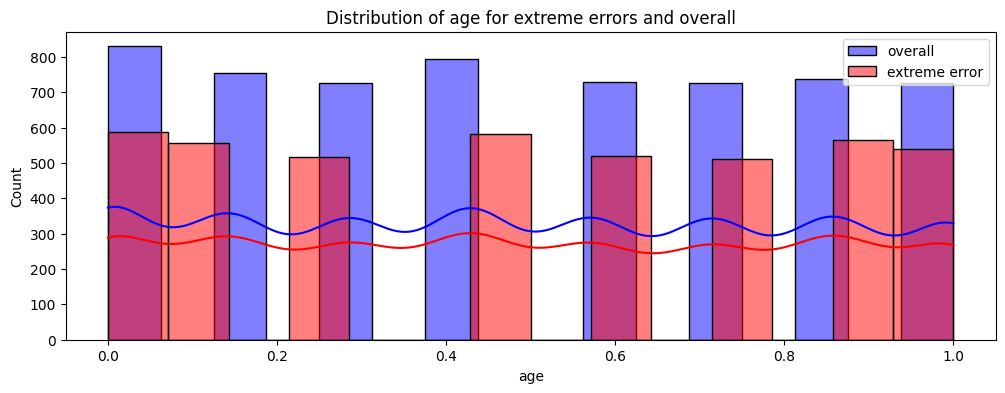

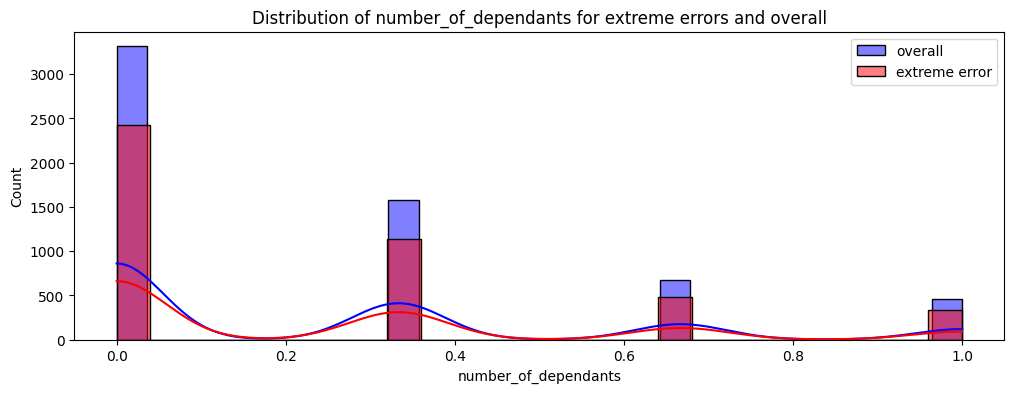

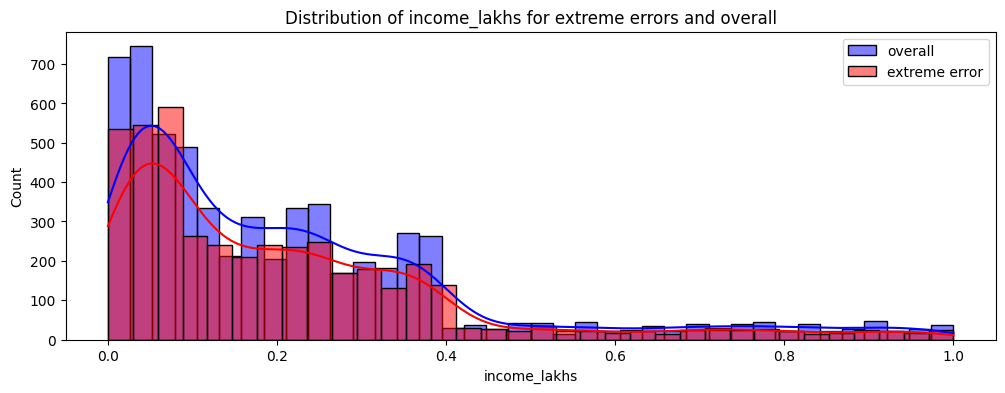

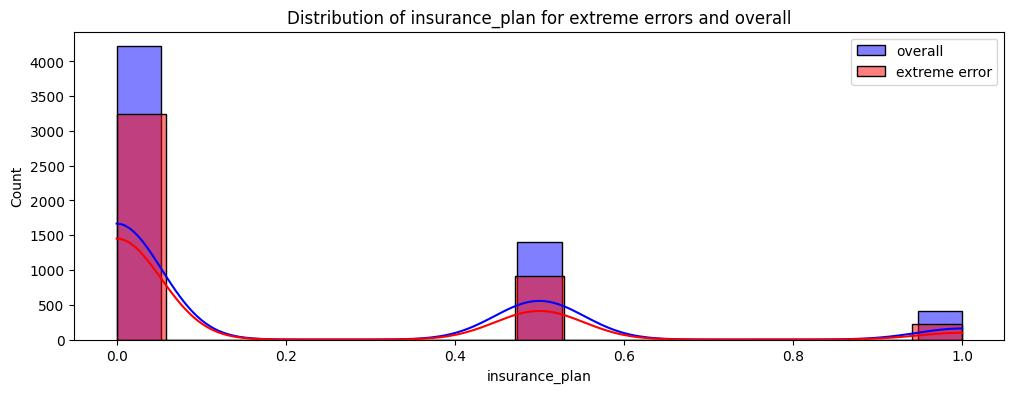

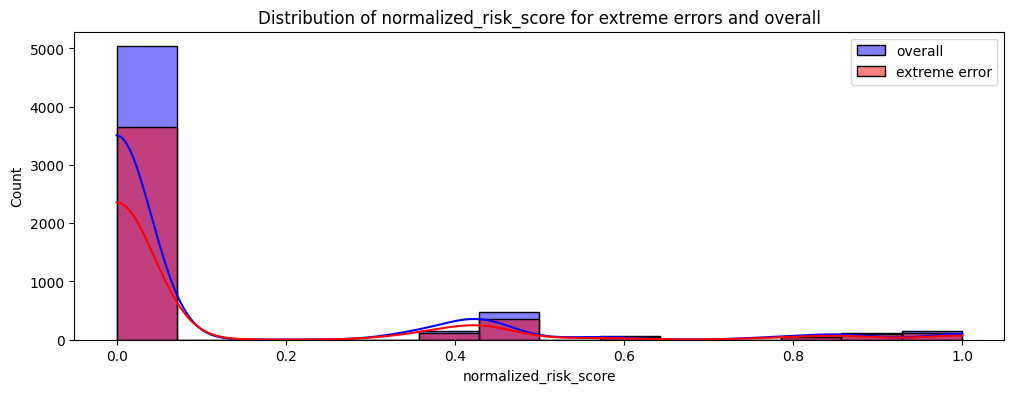

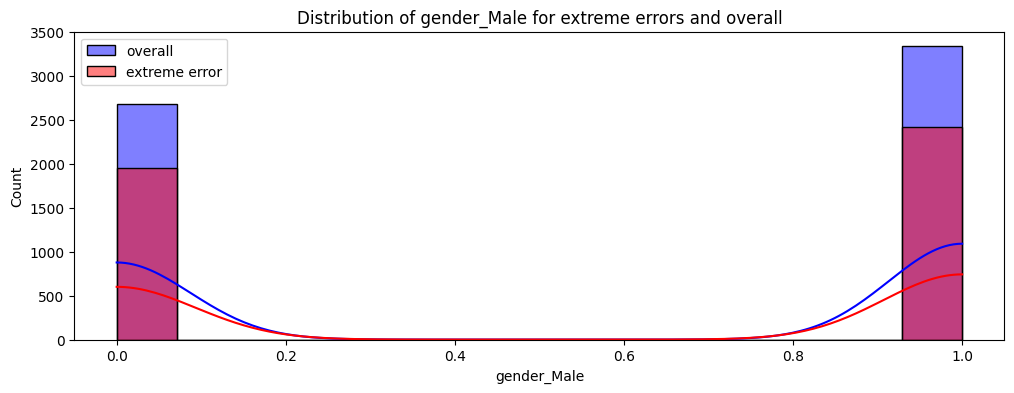

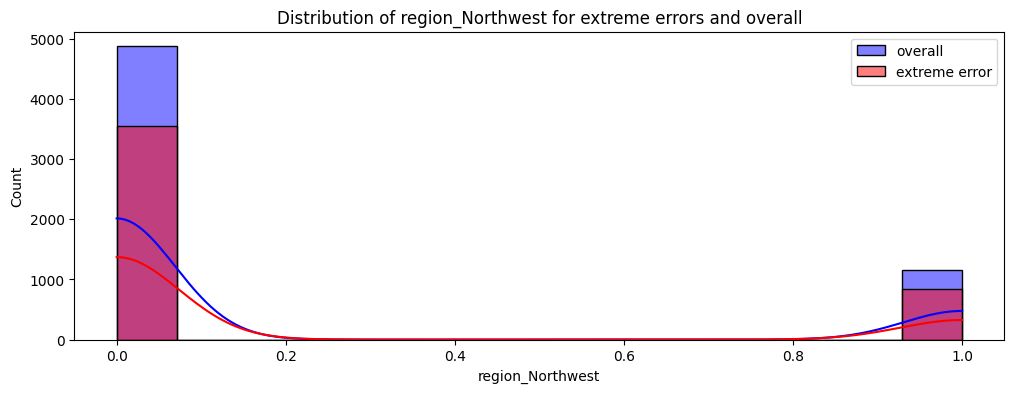

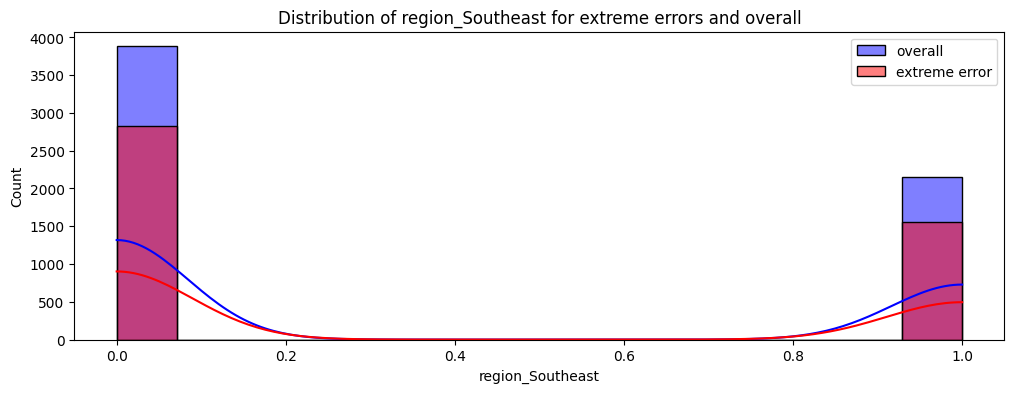

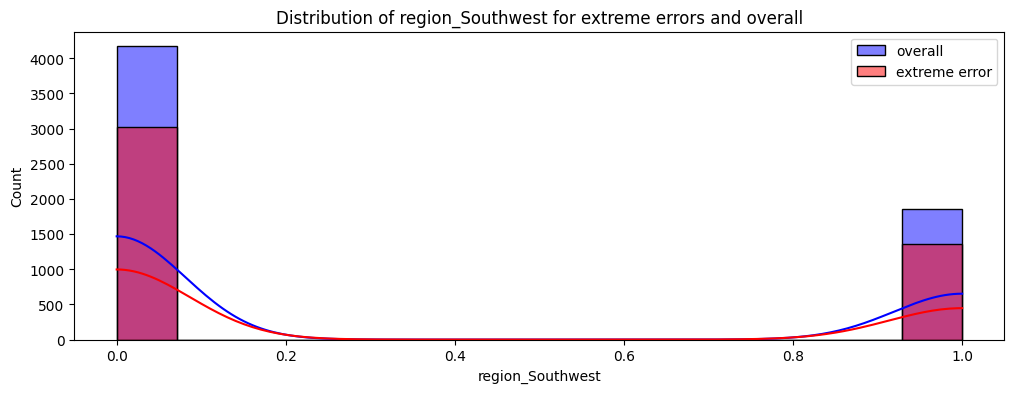

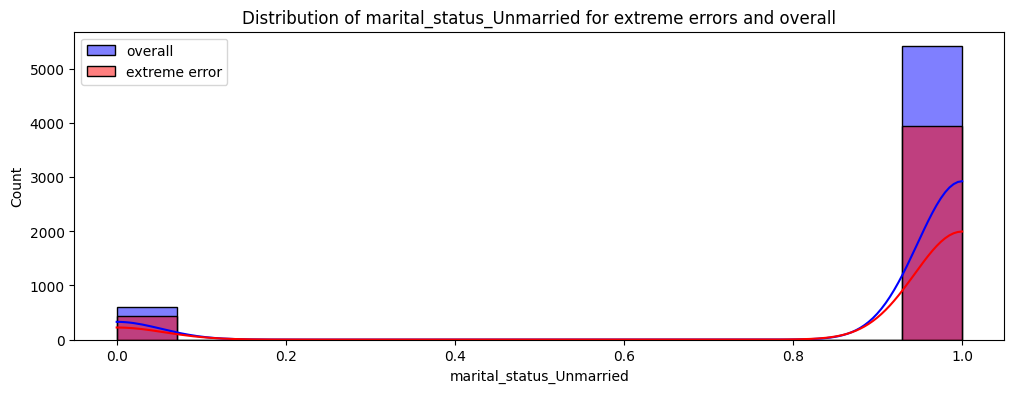

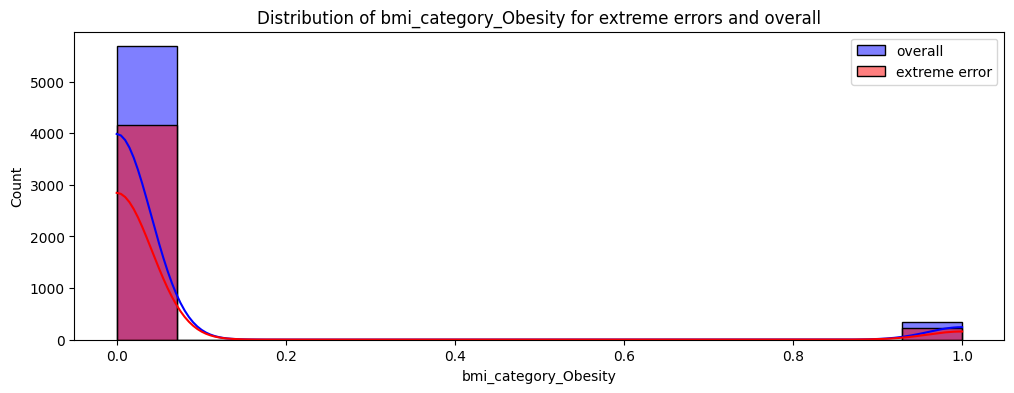

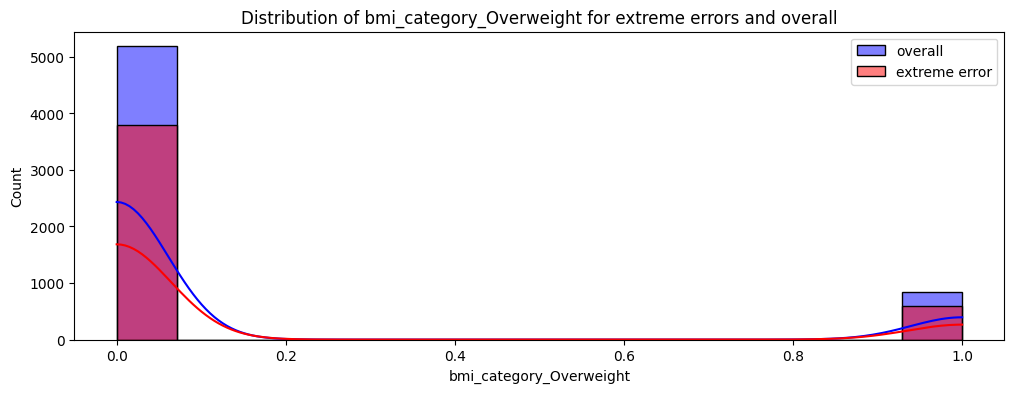

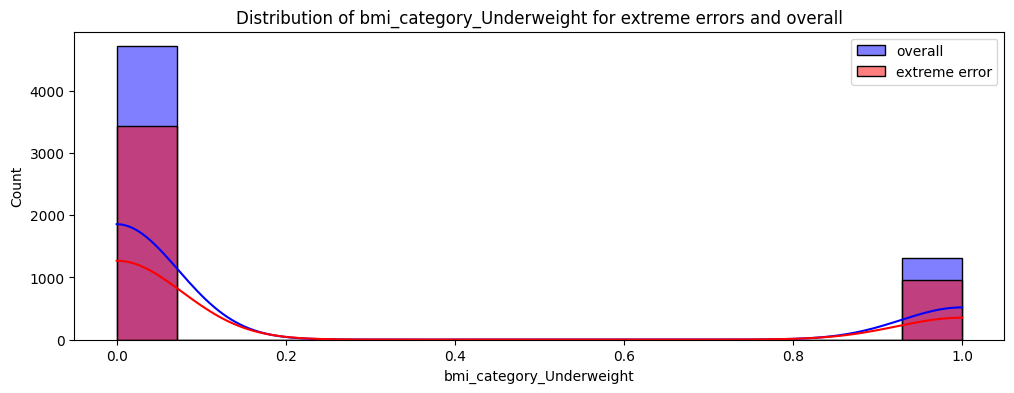

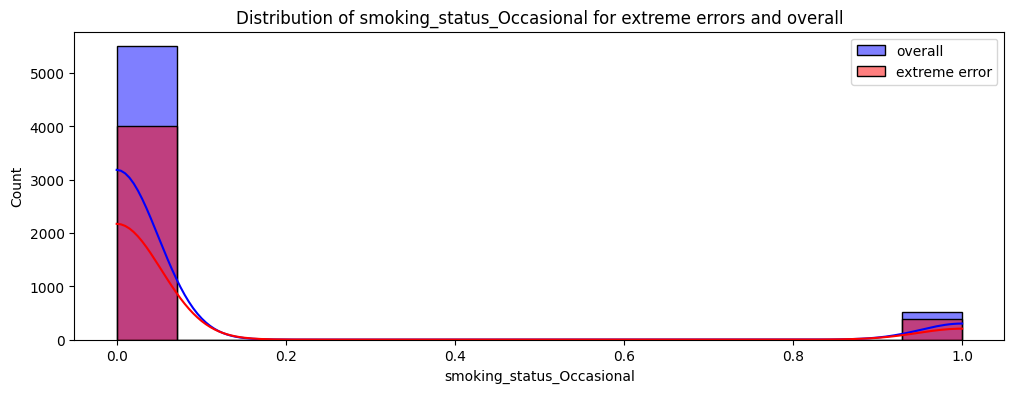

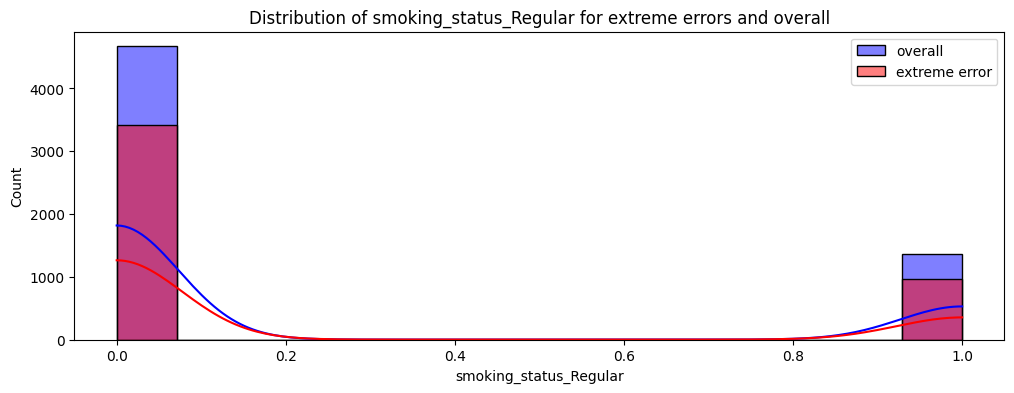

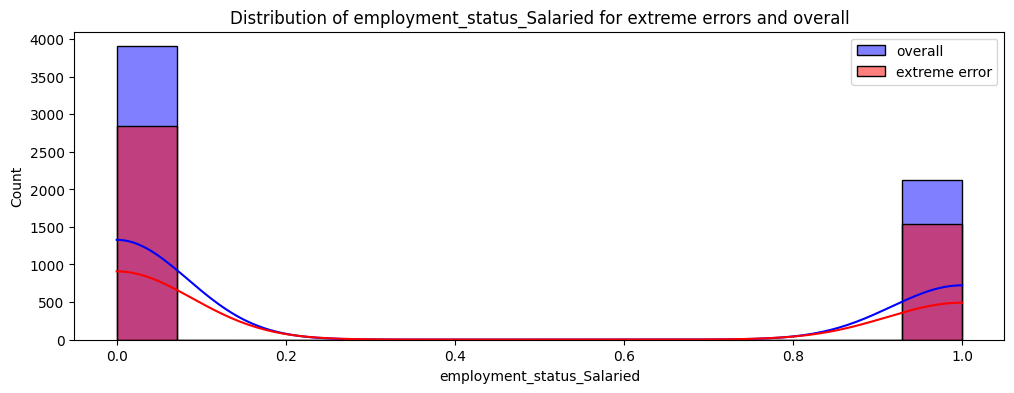

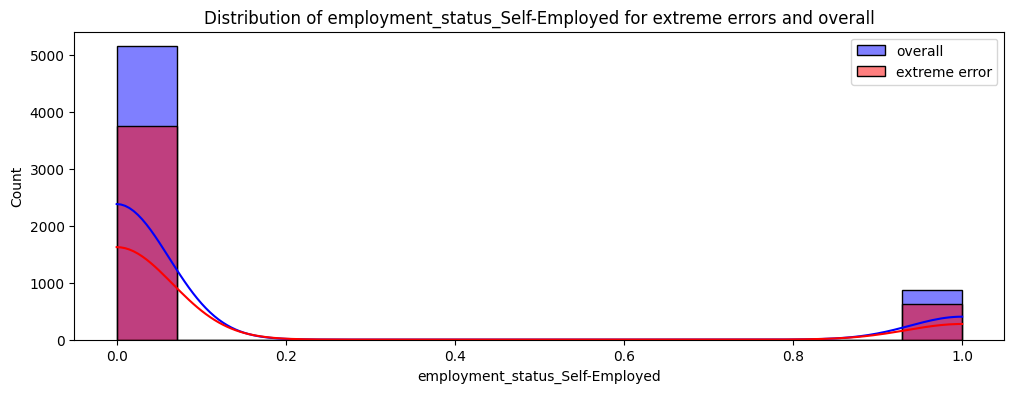

In [222]:
for columns in extreme_errors.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(X_test[columns], label='overall', kde=True, color='blue')
    sns.histplot(extreme_errors[columns],label='extreme error', kde=True, color='red',alpha=0.5)
    plt.legend()
    plt.title(f'Distribution of {columns} for extreme errors and overall')
    plt.show()

In [223]:
extreme_errors.sample(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4551,0.571429,0.0,0.070707,0.0,0.000000,1,0,0,1,1,0,0,0,1,0,1,0
7362,0.285714,0.0,0.525253,0.5,0.428571,0,0,0,1,1,0,1,0,0,0,0,1
1128,1.000000,0.0,0.060606,0.0,0.000000,0,0,1,0,1,0,1,0,0,0,0,0
15466,0.428571,0.0,0.080808,0.0,0.000000,1,0,1,0,1,0,0,1,0,0,0,0
359,0.571429,0.0,0.050505,0.0,0.000000,0,0,0,0,1,1,0,0,0,0,0,1


##  Reverse scaling

In [224]:
col_to_scale=cols
col_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [225]:
extreme_errors['income_level']=-1

In [226]:
extreme_errors=scaler.inverse_transform(extreme_errors[col_to_scale])
extreme_errors_df=pd.DataFrame(extreme_errors, columns=col_to_scale)
extreme_errors_df

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,21.0,3.0,-2.0,9.0,1.0
1,23.0,0.0,-2.0,4.0,1.0
2,19.0,0.0,-2.0,37.0,1.0
3,21.0,0.0,-2.0,52.0,2.0
4,18.0,0.0,-2.0,23.0,1.0
...,...,...,...,...,...
4376,20.0,1.0,-2.0,5.0,1.0
4377,21.0,1.0,-2.0,19.0,1.0
4378,24.0,1.0,-2.0,1.0,3.0
4379,24.0,0.0,-2.0,7.0,2.0


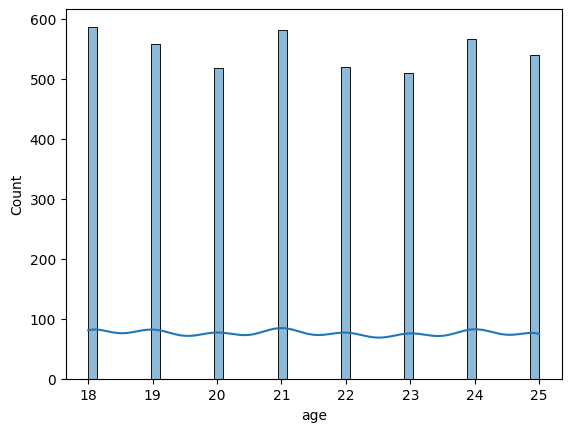

In [227]:
sns.histplot(extreme_errors_df['age'], kde=True, bins=50)
plt.show()

In [228]:
print(f"25th percentile--->{extreme_errors_df.age.quantile(0.25)}")
print(f"50th percentile--->{extreme_errors_df.age.quantile(0.50)}")
print(f"75th percentile--->{extreme_errors_df.age.quantile(0.75)}")
print(f"95th percentile--->{extreme_errors_df.age.quantile(0.95)}")
print(f"97th percentile--->{extreme_errors_df.age.quantile(0.97)}")
print(f"98th percentile--->{extreme_errors_df.age.quantile(0.98)}")
print(f"99th percentile--->{extreme_errors_df.age.quantile(0.99)}")
print(f"100th percentile--->{extreme_errors_df.age.quantile(1)}")

25th percentile--->19.0
50th percentile--->21.0
75th percentile--->24.0
95th percentile--->25.0
97th percentile--->25.0
98th percentile--->25.0
99th percentile--->25.0
100th percentile--->25.0


Most of the errors are coming from young age group whose age less than 25. We may need to build separate model for this.